In [1]:
import pandas as pd 
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math

In [22]:
# Import tables
precipitation_galapagos = pd.read_csv("precipitation_galapagos.csv")
climate_bellavista = pd.read_csv("climate_bellavista.csv")
climate_puerto_ayora = pd.read_csv("climate_puerto-ayora.csv")
average_galapagos = pd.read_csv("average_galapagos.csv")
oni = pd.read_csv("oni.csv")
eruptions = pd.read_csv("eruptions_galapagos.csv")

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_24399/3365707242.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  precipitation_galapagos = pd.read_csv("precipitation_galapagos.csv")


In [23]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,4) 
    return decimal_year

In [43]:
# Converts date information from ONI into numerical format

date_converter = {'DJF': ('12', '03', '01'), 'JFM': ('01', '04', '02'), 'FMA': ('02', '05', '03'), 'MAM': ('03', '06', '04'), 'AMJ': ('04', '07', '05'), 'MJJ': ('05', '08', '06'), 'JJA': ('06', '09', '07'), 'JAS': ('07', '10', '08'), 'ASO': ('08', '11', '09'), 'SON': ('09', '12', '10'), 'OND': ('10', '01', '11'), 'NDJ': ('11', '02', '12')}

def convert_start(row):
    if row['SEAS'] == 'DJF':
        return str(row['YR']-1) + '-' + date_converter[row['SEAS']][0] + '-01'
    else:
        return str(row['YR']) + '-' + date_converter[row['SEAS']][0] + '-01' 

def convert_end(row):
    if row['SEAS'] == 'NDJ':
        return str(row['YR']+1) + '-' + date_converter[row['SEAS']][1] + '-01'
    else: 
        return str(row['YR']) + '-' + date_converter[row['SEAS']][1] + '-01' 

def convert_mid(row):
    return str(row['YR']) + '-' + date_converter[row['SEAS']][2] + '-15' 

oni['Start'] = oni.apply(convert_start, axis=1)
oni['End'] = oni.apply(convert_end, axis=1)
oni['Center'] = oni.apply(convert_mid, axis=1)

In [44]:
print(oni)

    SEAS    YR  TOTAL  ANOM       Start         End      Center
0    DJF  1950  24.72 -1.53  1949-12-01  1950-03-01  1950-01-15
1    JFM  1950  25.17 -1.34  1950-01-01  1950-04-01  1950-02-15
2    FMA  1950  25.75 -1.16  1950-02-01  1950-05-01  1950-03-15
3    MAM  1950  26.12 -1.18  1950-03-01  1950-06-01  1950-04-15
4    AMJ  1950  26.32 -1.07  1950-04-01  1950-07-01  1950-05-15
..   ...   ...    ...   ...         ...         ...         ...
879  MAM  2023  27.85  0.16  2023-03-01  2023-06-01  2023-04-15
880  AMJ  2023  28.31  0.48  2023-04-01  2023-07-01  2023-05-15
881  MJJ  2023  28.43  0.77  2023-05-01  2023-08-01  2023-06-15
882  JJA  2023  28.36  1.07  2023-06-01  2023-09-01  2023-07-15
883  JAS  2023  28.28  1.32  2023-07-01  2023-10-01  2023-08-15

[884 rows x 7 columns]


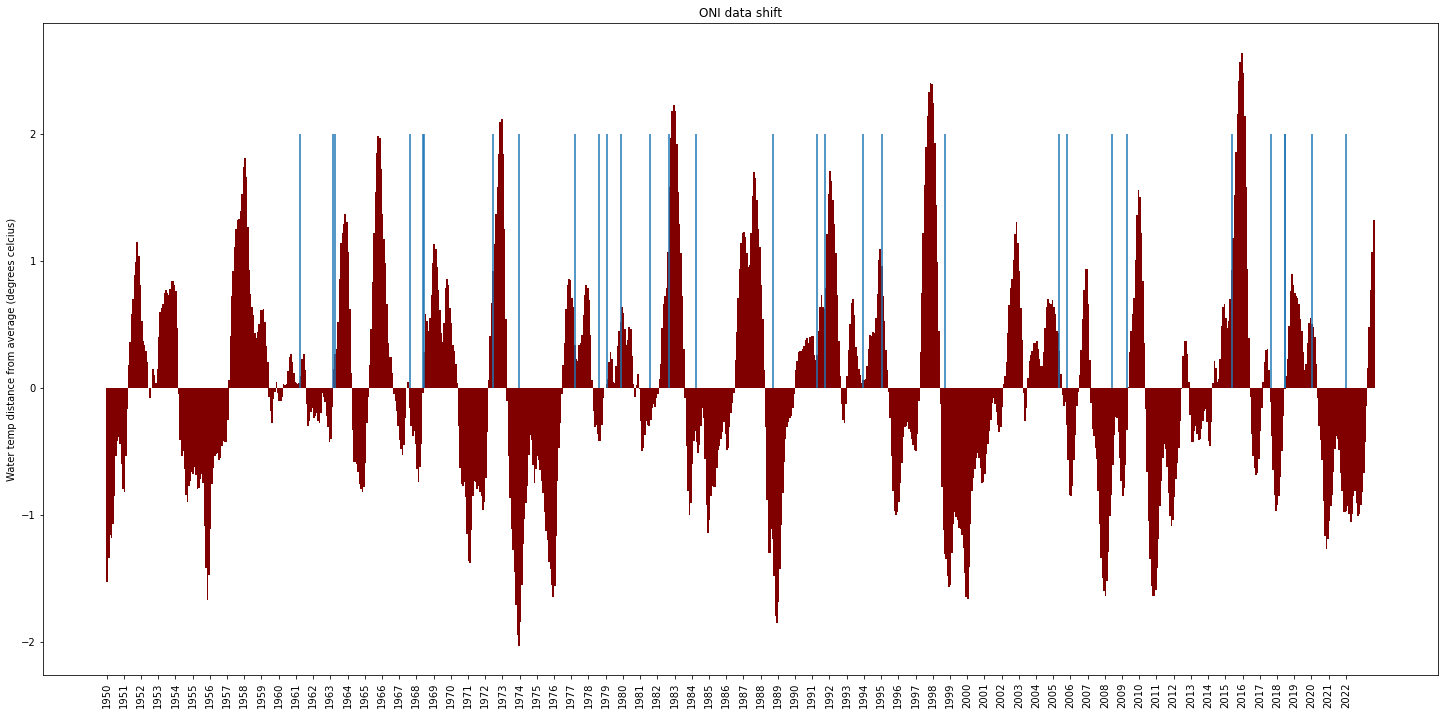

In [47]:
eruption_lines = eruptions['Start'].apply(date_to_decimal_year)

# Convert date strings to decimal years
decimal_year = np.array(oni['Center'].apply(date_to_decimal_year))

plt.figure(figsize=(25,12))

plt.bar(decimal_year, oni['ANOM'], color ='maroon',
       width = 0.1)

plt.vlines(eruption_lines, 0, 2)

plt.ylabel("Water temp distance from average (degrees celcius)")
 
plt.title('ONI data shift')

plt.xticks(ticks=[1950 + i for i in range(73)], rotation=90)

# Data plot
plt.show()

/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_24399/2265876740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversed_average_galapagos['roll_av'] = reversed_average_galapagos.Precipitation.rolling(91).mean() - average


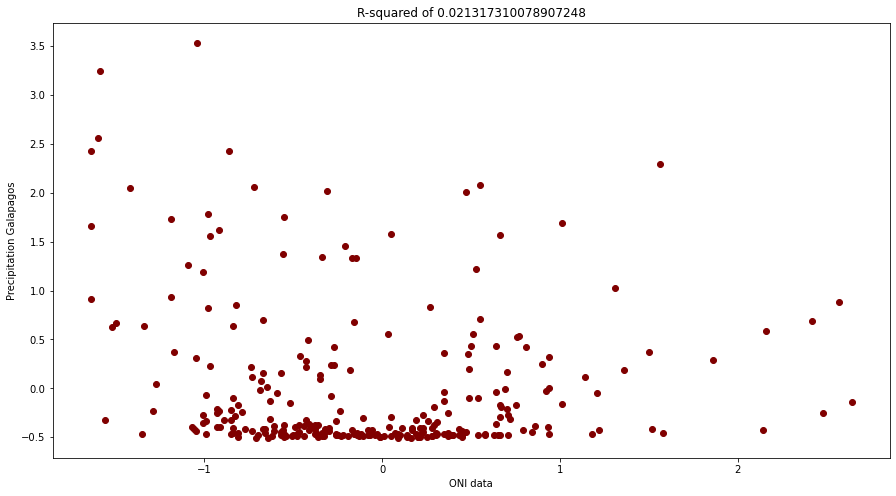

In [50]:
# Performs linear regression on ONI versus Galapagos rainfall data
average = average_galapagos['Precipitation'].mean()

reversed_average_galapagos = average_galapagos.iloc[::-1]
reversed_average_galapagos['roll_av'] = reversed_average_galapagos.Precipitation.rolling(91).mean() - average
reversed_average_galapagos = reversed_average_galapagos.dropna()
result = pd.merge(oni, reversed_average_galapagos, left_on='End', right_on='Date', how='inner').sort_values(by=['roll_av'])

x = np.array(result['ANOM'][result['Date'] > '2000'])
y = np.array(result['roll_av'][result['Date'] > '2000'])
X_constants = sm.add_constant(x)
model_sm = sm.OLS(y, X_constants).fit()

r_squared = model_sm.rsquared

plt.figure(figsize=(15,8))

plt.scatter(x, y, color ='maroon')

plt.xlabel("ONI data") 
plt.ylabel("Precipitation Galapagos") 
plt.title('R-squared of ' + str(r_squared)) 
# Data plot
plt.show()


The statistics are better when we shift rainfall by three months.

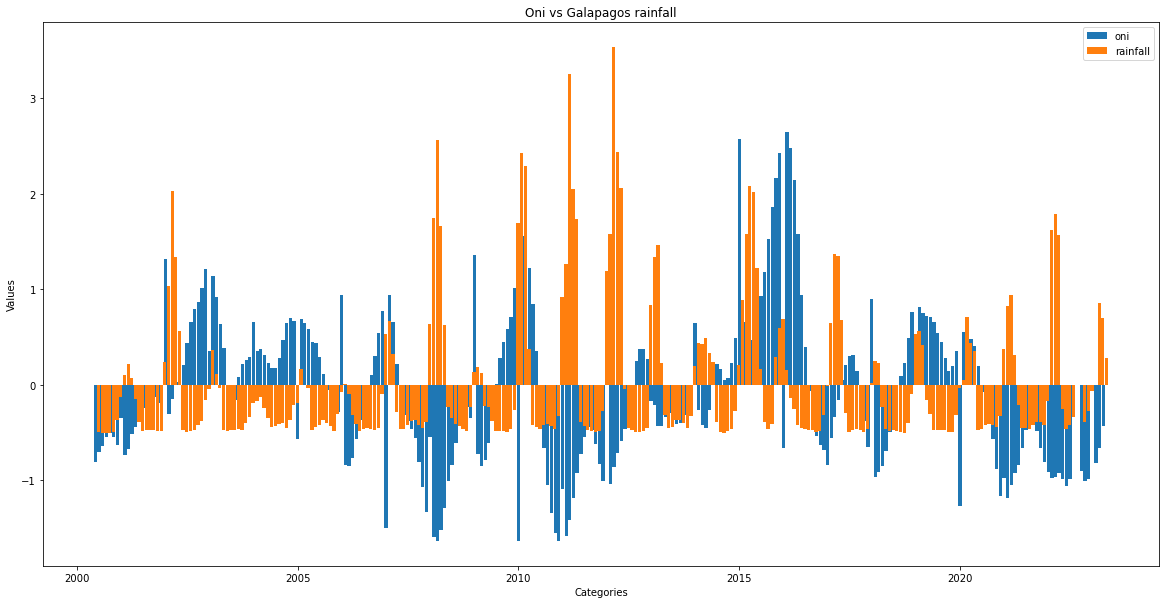

In [51]:
# Plots rainfall and ONI data as time series.

plt.figure(figsize=(20,10))
plt.bar(x= np.array(result['Date'].apply(date_to_decimal_year)), height=x, width=.075, label='oni')
plt.bar(x= np.array(result['Date'].apply(date_to_decimal_year)) + .075, height=y, width=.075, label='rainfall')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Oni vs Galapagos rainfall')
plt.legend()

plt.show()

In [10]:
# Pick out columns of interest

#precipitation_bellavista = climate_bellavista[['observation_date', 'precipitation']]
precipitation_ayora = climate_puerto_ayora[['observation_date', 'precipitation']]

In [11]:
#new_era_bellavista = precipitation_bellavista[(precipitation_bellavista['observation_date'] >= '2000-06-01') & (precipitation_bellavista['observation_date'] < '2014-05-28')]
#new_era_galapagos = precipitation_galapagos[precipitation_galapagos['Date'] < '2014-05-28']
new_era_ayora = precipitation_ayora[precipitation_ayora['observation_date'] >= '2000-06-01']
new_era_galapagos = precipitation_galapagos.copy()

In [23]:
# # For indiviual volcanoes
# locations = {'Wolf': ('Wolf', 0.0, -91.20), 'Fernandina': ('Fernandina', -0.22, -91.33), 'Sierra Negra': ('Negra, Sierra', -0.83, -91.17), 'Cerro Azul': ('Azul, Cerro', -0.55, -91.24), 'Alcedo': ('Alcedo', -0.26, -91.07), 'Marchena': ('Marchena', 0.35, -90.5), 'Puerto Ayora': ('Puerto Ayora', -0.74, -90.30), 'Bellavista': ('Bellavista', -0.69, -90.33), 'Sierra Negra south coast': ('Negra, Sierra', -1.01, -91.12), 'Sierra Negra south of caldera': ('Negra, Sierra', -0.86, -91.12), 'Sierra Negra north coast': ('Negra, Sierra', -0.65, -91.12)}
# pick = 'Sierra Negra' # enter desired volcano name here
# lat_range = .1 # enter desired latitude range
# lon_range = .1 # enter desired longitude range

# lat = locations[pick][1]
# lon = locations[pick][2]
# new_era_galapagos['Longitude'] = pd.to_numeric(new_era_galapagos['Longitude'], errors='coerce')
# new_era_galapagos['Latitude'] = pd.to_numeric(new_era_galapagos['Latitude'], errors='coerce')

# nearby_rain = new_era_galapagos[(abs(lon - new_era_galapagos['Longitude']) <= lon_range) & (abs(lat - new_era_galapagos['Latitude']) <= lat_range)]
# dates = np.sort(nearby_rain['Date'].unique())
# averages = [[date, nearby_rain['Precipitation'][nearby_rain['Date'] == date].mean()] for date in dates]
# average_rain = pd.DataFrame(averages, columns = ['observation_date', 'Precipitation' + str(pick)])


In [15]:
#bell_compare = new_era_bellavista.merge(average_rain, on='observation_date', how='inner')
ayora_compare = new_era_ayora.merge(average_galapagos, left_on='observation_date', right_on='Date', how='inner')

In [18]:
# Do a regression
ayora_sum = ayora_compare['precipitation'].rolling(90).sum().dropna()
volcano_sum = ayora_compare['Precipitation'].rolling(90).sum().dropna()

X_constants = sm.add_constant(ayora_sum)
model_sm = sm.OLS(volcano_sum, X_constants).fit()

r_squared = model_sm.rsquared
print(r_squared)

0.7489502559824147


In [19]:
print(model_sm.params)

const            0.912098
precipitation    0.531768
dtype: float64


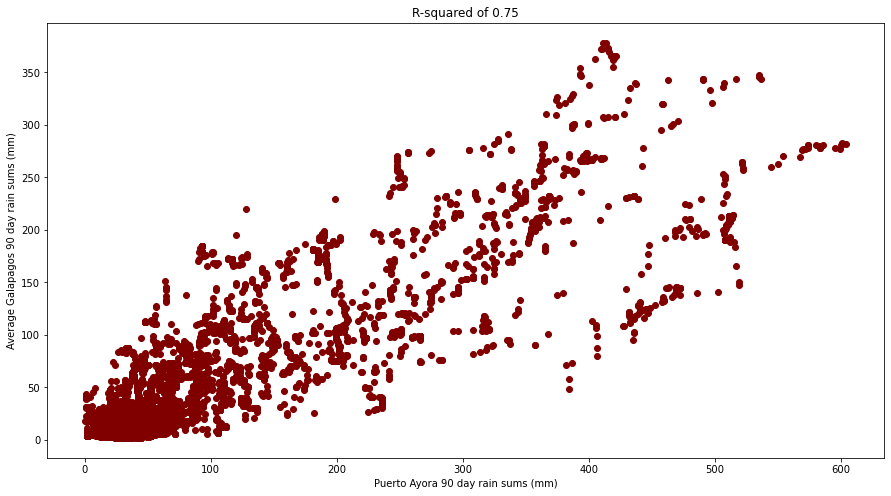

In [20]:
plt.figure(figsize=(15,8))

plt.scatter(ayora_sum, volcano_sum, color ='maroon')

plt.xlabel("Puerto Ayora 90 day rain sums (mm)") 
plt.ylabel("Average Galapagos 90 day rain sums (mm)") 
plt.title('R-squared of 0.75') 
# Data plot
plt.show()